Датасет: Flight Price Prediction

Целевая переменная: Price (цена билета)

Подготовка окружения и загрузка данных

In [23]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

# Загрузка данных
df = pd.read_csv('Clean_Dataset.csv')

# Первичный осмотр
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nПропуски:")
print(df.isnull().sum())
print("\nДубликаты:", df.duplicated().sum())

Размер данных: (300153, 12)

Первые 5 строк:
   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Da

EDA

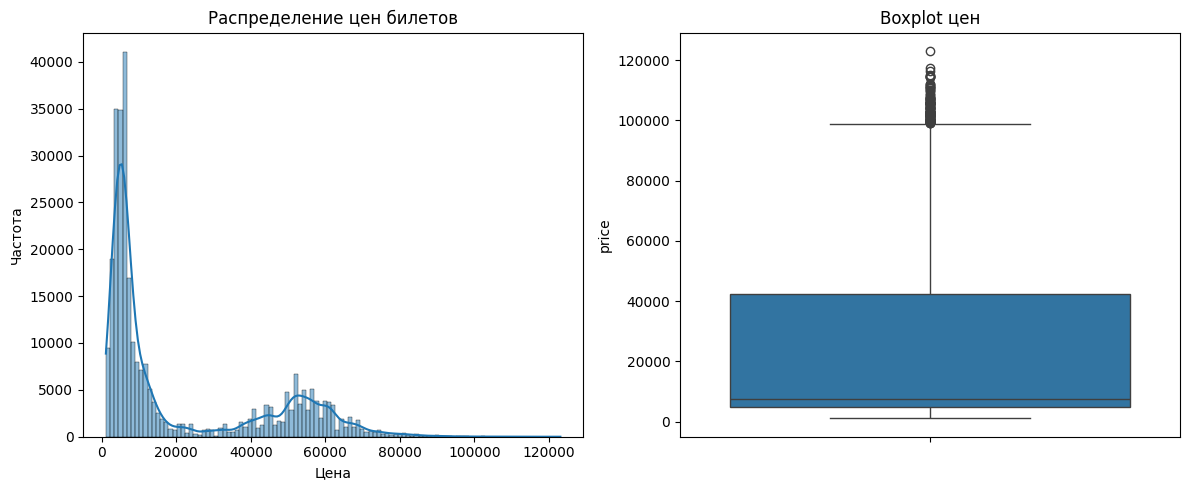

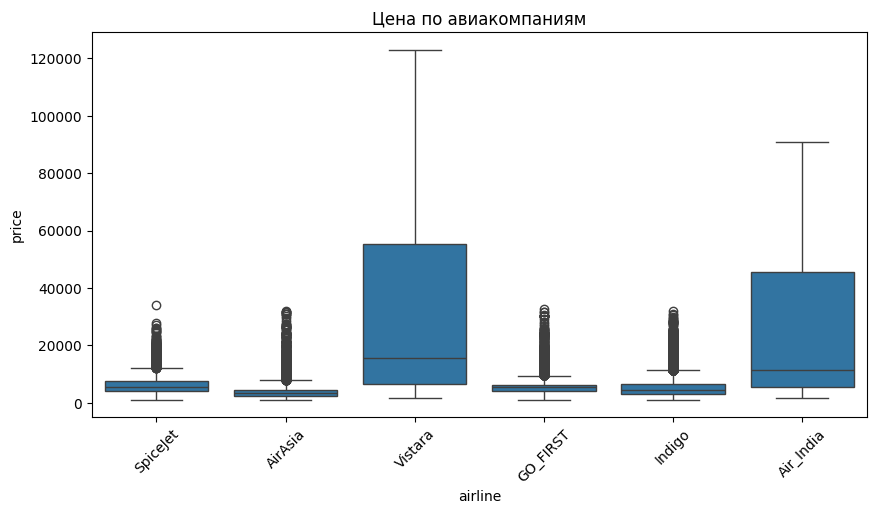

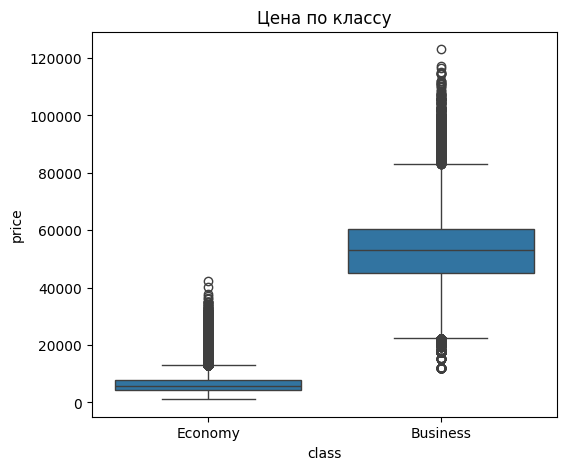

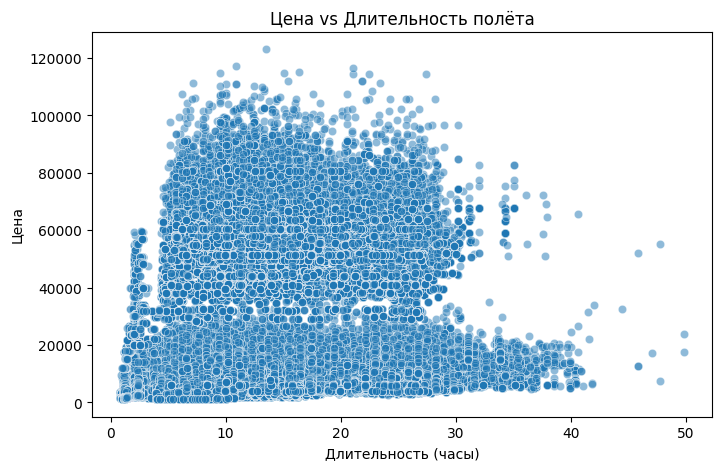

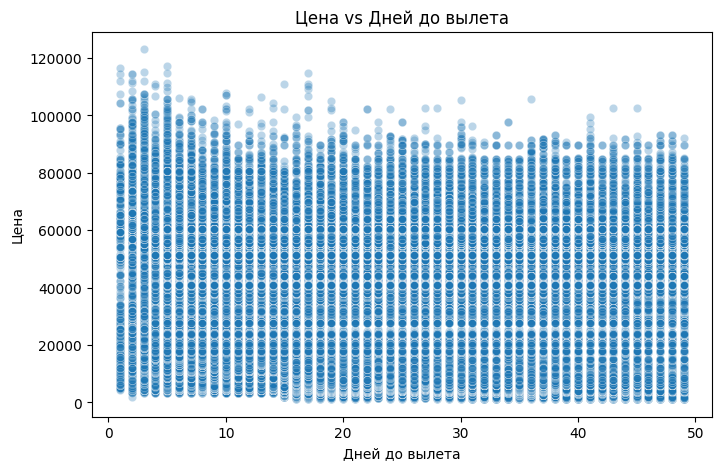

In [24]:
# Удалим ненужную колонку (если есть Unnamed: 0)
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# 1. Распределение целевой переменной
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Распределение цен билетов')
plt.xlabel('Цена')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'])
plt.title('Boxplot цен')

plt.tight_layout()
plt.show()

# 2. Цена по авиакомпаниям
plt.figure(figsize=(10, 5))
sns.boxplot(x='airline', y='price', data=df)
plt.title('Цена по авиакомпаниям')
plt.xticks(rotation=45)
plt.show()

# 3. Цена по классу
plt.figure(figsize=(6, 5))
sns.boxplot(x='class', y='price', data=df)
plt.title('Цена по классу')
plt.show()

# 4. Зависимость цены от продолжительности полёта
plt.figure(figsize=(8, 5))
sns.scatterplot(x='duration', y='price', data=df, alpha=0.5)
plt.title('Цена vs Длительность полёта')
plt.xlabel('Длительность (часы)')
plt.ylabel('Цена')
plt.show()

# 5. Зависимость цены от дней до вылета
plt.figure(figsize=(8, 5))
sns.scatterplot(x='days_left', y='price', data=df, alpha=0.3)
plt.title('Цена vs Дней до вылета')
plt.xlabel('Дней до вылета')
plt.ylabel('Цена')
plt.show()

Подготовка данных для моделирования

In [25]:
# Проверим текущие столбцы
print("Текущие столбцы:", df.columns.tolist())

X = df.drop(columns=['price'])
y = df['price']

print(f"\nПризнаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")

Текущие столбцы: ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']

Признаки (X): (300153, 10)
Целевая переменная (y): (300153,)


In [26]:
print("="*60)
print("ШАГ 3 (ОПТИМИЗИРОВАННЫЙ): Подготовка данных")
print("="*60)

# Удаляем 'flight' - слишком много уникальных значений, мало информативности
cat_features_opt = ['airline', 'source_city', 'departure_time', 'stops',
                   'arrival_time', 'destination_city', 'class']
num_features_opt = ['duration', 'days_left']

print(f"Категориальные признаки ({len(cat_features_opt)}): {cat_features_opt}")
print(f"Числовые признаки ({len(num_features_opt)}): {num_features_opt}")

# Разделение на train/test (уже сделано, используем существующие)
print(f"\nИспользуем существующие разделения:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# Удаляем flight из данных
X_train_opt = X_train.drop(columns=['flight'])
X_test_opt = X_test.drop(columns=['flight'])

# Создаём оптимизированный пайплайн
preprocessor_opt = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_opt),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features_opt)
    ]
)

# Применяем преобразования
print("\nПрименяем оптимизированные преобразования...")
X_train_opt_processed = preprocessor_opt.fit_transform(X_train_opt)
X_test_opt_processed = preprocessor_opt.transform(X_test_opt)

# Получаем имена признаков
feature_names_opt = num_features_opt + list(preprocessor_opt.named_transformers_['cat'].get_feature_names_out(cat_features_opt))

print(f"\nРазмер после оптимизированной обработки:")
print(f"X_train_opt_processed: {X_train_opt_processed.shape}")
print(f"X_test_opt_processed: {X_test_opt_processed.shape}")
print(f"Количество признаков уменьшено с 1589 до {X_train_opt_processed.shape[1]}")

ШАГ 3 (ОПТИМИЗИРОВАННЫЙ): Подготовка данных
Категориальные признаки (7): ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
Числовые признаки (2): ['duration', 'days_left']

Используем существующие разделения:
X_train: (113638, 10), X_test: (28410, 10)

Применяем оптимизированные преобразования...

Размер после оптимизированной обработки:
X_train_opt_processed: (113638, 28)
X_test_opt_processed: (28410, 28)
Количество признаков уменьшено с 1589 до 28


Создание бейзлайна и оценка качества

In [29]:
# Проверим на NaN значения
print("Проверяем на NaN значения в обработанных данных...")
print(f"NaN в X_train_opt_processed: {np.isnan(X_train_opt_processed).sum()}")
print(f"NaN в X_test_opt_processed: {np.isnan(X_test_opt_processed).sum()}")
print(f"NaN в y_train: {pd.isna(y_train).sum()}")
print(f"NaN в y_test: {pd.isna(y_test).sum()}")

# Посмотрим на данные до обработки
print("\nПроверяем исходные данные на пропуски:")
print("В исходном df:")
print(df.isnull().sum())

print("\nВ X_train_opt:")
print(X_train_opt.isnull().sum())

print("\nВ X_test_opt:")
print(X_test_opt.isnull().sum())

Проверяем на NaN значения в обработанных данных...
NaN в X_train_opt_processed: 2
NaN в X_test_opt_processed: 0
NaN в y_train: 1
NaN в y_test: 0

Проверяем исходные данные на пропуски:
В исходном df:
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

В X_train_opt:
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               1
duration            1
days_left           1
dtype: int64

В X_test_opt:
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
dtype: int64


In [30]:
# Обработка NaN значений
print("\nОбработка NaN значений...")


X_train_opt_processed = np.nan_to_num(X_train_opt_processed, nan=0.0)
X_test_opt_processed = np.nan_to_num(X_test_opt_processed, nan=0.0)

print(f"После обработки:")
print(f"NaN в X_train_opt_processed: {np.isnan(X_train_opt_processed).sum()}")
print(f"NaN в X_test_opt_processed: {np.isnan(X_test_opt_processed).sum()}")

# Также проверим и обработаем y если нужно
if pd.isna(y_train).sum() > 0 or pd.isna(y_test).sum() > 0:
    print("\n⚠️ Внимание: есть NaN в целевой переменной!")
    print("Заполняем медианой...")
    y_train = y_train.fillna(y_train.median())
    y_test = y_test.fillna(y_test.median())


Обработка NaN значений...
После обработки:
NaN в X_train_opt_processed: 0
NaN в X_test_opt_processed: 0

⚠️ Внимание: есть NaN в целевой переменной!
Заполняем медианой...


In [31]:
print("\n" + "="*60)
print("ШАГ 4 (ОПТИМИЗИРОВАННЫЙ): Бейзлайн модель (после обработки NaN)")
print("="*60)

# Создаём и обучаем модель
model_opt = LinearRegression()
print("Обучаем оптимизированную модель...")
start_time = time.time()
model_opt.fit(X_train_opt_processed, y_train)
training_time = time.time() - start_time

# Предсказания
y_pred_opt = model_opt.predict(X_test_opt_processed)

# Метрики
mae_opt = mean_absolute_error(y_test, y_pred_opt)
mse_opt = mean_squared_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mse_opt)
r2_opt = r2_score(y_test, y_pred_opt)

print(f"\n⏱ Время обучения: {training_time:.2f} секунд")
print("\n📊 Результаты оптимизированного бейзлайна:")
print(f"MAE: {mae_opt:.2f}")
print(f"MSE: {mse_opt:.2f}")
print(f"RMSE: {rmse_opt:.2f}")
print(f"R²: {r2_opt:.4f}")

# Проверим размерности
print(f"\nРазмерности данных:")
print(f"X_train_opt_processed: {X_train_opt_processed.shape}")
print(f"X_test_opt_processed: {X_test_opt_processed.shape}")
print(f"y_train: {y_train.shape if hasattr(y_train, 'shape') else len(y_train)}")
print(f"y_test: {y_test.shape if hasattr(y_test, 'shape') else len(y_test)}")


ШАГ 4 (ОПТИМИЗИРОВАННЫЙ): Бейзлайн модель (после обработки NaN)
Обучаем оптимизированную модель...

⏱ Время обучения: 0.53 секунд

📊 Результаты оптимизированного бейзлайна:
MAE: 1894.33
MSE: 6866198.32
RMSE: 2620.34
R²: 0.4891

Размерности данных:
X_train_opt_processed: (113638, 28)
X_test_opt_processed: (28410, 28)
y_train: (113638,)
y_test: (28410,)


Улучшение бейзлайна

In [36]:
print("\n" + "="*60)
print("ШАГ 5: Улучшение бейзлайна")
print("="*60)

# Импортируем необходимые библиотеки
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Сохраним текущие результаты для сравнения
baseline_results = {
    'MAE': mae_opt,
    'MSE': mse_opt,
    'RMSE': rmse_opt,
    'R2': r2_opt,
    'time': training_time,
    'n_features': X_train_opt_processed.shape[1]
}

print(f"📈 Бейзлайн результаты (для сравнения):")
print(f"R²: {baseline_results['R2']:.4f}")
print(f"RMSE: {baseline_results['RMSE']:.2f}")
print(f"MAE: {baseline_results['MAE']:.2f}")
print(f"Время обучения: {baseline_results['time']:.2f} сек")
print(f"Количество признаков: {baseline_results['n_features']}")

# Гипотезы для улучшения:
print("\n📝 Гипотезы для улучшения модели:")
print("1. Добавление полиномиальных признаков для числовых переменных")
print("2. Использование регуляризации (Ridge/Lasso/ElasticNet)")
print("3. Создание новых признаков (взаимодействия, бинарные признаки)")
print("4. Подбор гиперпараметров на кросс-валидации")

# Создадим функцию для сравнения моделей
def compare_models(model_name, y_pred, y_true, fit_time, n_features=None):
    """Сравнивает модель с бейзлайном"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    mae_diff = mae - baseline_results['MAE']
    rmse_diff = rmse - baseline_results['RMSE']
    r2_diff = r2 - baseline_results['R2']

    print(f"\n📊 {model_name}:")
    print(f"  R²: {r2:.4f} ({'↑' if r2_diff > 0 else '↓'}{abs(r2_diff):.4f})")
    print(f"  RMSE: {rmse:.2f} ({'↓' if rmse_diff < 0 else '↑'}{abs(rmse_diff):.2f})")
    print(f"  MAE: {mae:.2f} ({'↓' if mae_diff < 0 else '↑'}{abs(mae_diff):.2f})")
    print(f"  Время: {fit_time:.2f} сек")
    if n_features:
        print(f"  Признаков: {n_features}")

    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'time': fit_time}


ШАГ 5: Улучшение бейзлайна
📈 Бейзлайн результаты (для сравнения):
R²: 0.4891
RMSE: 2620.34
MAE: 1894.33
Время обучения: 0.53 сек
Количество признаков: 28

📝 Гипотезы для улучшения модели:
1. Добавление полиномиальных признаков для числовых переменных
2. Использование регуляризации (Ridge/Lasso/ElasticNet)
3. Создание новых признаков (взаимодействия, бинарные признаки)
4. Подбор гиперпараметров на кросс-валидации


In [38]:
from sklearn.impute import SimpleImputer

In [40]:
# Гипотеза 1: Добавление полиномиальных признаков
print("\n" + "-"*50)
print("ГИПОТЕЗА 1: Полиномиальные признаки")
print("-"*50)

# Создадим пайплайн с полиномиальными признаками (степень 2)
poly_pipeline = Pipeline([
    ('preprocessor', preprocessor_opt),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

print("Обучаем модель с полиномиальными признаками (degree=2)...")
start_time = time.time()
poly_pipeline.fit(X_train_opt, y_train)
poly_time = time.time() - start_time

# Предсказания
y_pred_poly = poly_pipeline.predict(X_test_opt)

# Сравним с бейзлайном
try:
    n_poly_features = poly_pipeline.named_steps['poly'].n_output_features_
except:
    # Если не удается получить количество признаков напрямую
    n_poly_features = "много"

poly_results = compare_models(
    "Полиномиальная регрессия (degree=2)",
    y_pred_poly, y_test, poly_time,
    n_poly_features
)

# Гипотеза 2: Регуляризация (Ridge)
print("\n" + "-"*50)
print("ГИПОТЕЗА 2: Регуляризация (Ridge)")
print("-"*50)

# Ridge регрессия
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor_opt),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('model', Ridge(alpha=1.0))  # начальное значение alpha
])

print("Обучаем Ridge регрессию (alpha=1.0)...")
start_time = time.time()
ridge_pipeline.fit(X_train_opt, y_train)
ridge_time = time.time() - start_time

# Предсказания
y_pred_ridge = ridge_pipeline.predict(X_test_opt)

# Сравним
ridge_results = compare_models("Ridge регрессия (alpha=1.0)", y_pred_ridge, y_test, ridge_time)

# Подбор лучшего alpha для Ridge
print("\n" + "-"*50)
print("Подбор гиперпараметра alpha для Ridge...")
print("-"*50)

# Создадим пайплайн для GridSearch
ridge_gs_pipeline = Pipeline([
    ('preprocessor', preprocessor_opt),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('model', Ridge())
])

# Параметры для поиска
param_grid = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# GridSearch с кросс-валидацией
print("Запускаем GridSearchCV (5-fold CV)...")
ridge_gs = GridSearchCV(
    ridge_gs_pipeline,
    param_grid,
    cv=3,  # уменьшим для скорости
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
ridge_gs.fit(X_train_opt, y_train)
ridge_gs_time = time.time() - start_time

print(f"\nЛучшие параметры: {ridge_gs.best_params_}")
print(f"Лучший score (neg MSE): {ridge_gs.best_score_:.2f}")

# Предсказания лучшей модели
y_pred_ridge_gs = ridge_gs.predict(X_test_opt)

# Сравним
ridge_gs_results = compare_models(
    f"Ridge регрессия (оптимизированная, alpha={ridge_gs.best_params_['model__alpha']})",
    y_pred_ridge_gs, y_test, ridge_gs_time
)

# Гипотеза 3: Lasso регрессия (отбор признаков)
print("\n" + "-"*50)
print("ГИПОТЕЗА 3: Lasso регрессия (отбор признаков)")
print("-"*50)

# Lasso регрессия
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor_opt),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('model', Lasso(alpha=0.1, max_iter=10000))
])

print("Обучаем Lasso регрессию (alpha=0.1)...")
start_time = time.time()
lasso_pipeline.fit(X_train_opt, y_train)
lasso_time = time.time() - start_time

# Предсказания
y_pred_lasso = lasso_pipeline.predict(X_test_opt)

# Сравним
lasso_results = compare_models("Lasso регрессия (alpha=0.1)", y_pred_lasso, y_test, lasso_time)

# Посмотрим, сколько признаков отобрал Lasso
try:
    n_selected_features = np.sum(lasso_pipeline.named_steps['model'].coef_ != 0)
    print(f"Отобрано признаков Lasso: {n_selected_features} из {X_train_opt_processed.shape[1]}")
except:
    print("Не удалось получить количество отобранных признаков")


--------------------------------------------------
ГИПОТЕЗА 1: Полиномиальные признаки
--------------------------------------------------
Обучаем модель с полиномиальными признаками (degree=2)...

📊 Полиномиальная регрессия (degree=2):
  R²: 0.6542 (↑0.1651)
  RMSE: 2155.82 (↓464.53)
  MAE: 1449.73 (↓444.60)
  Время: 19.56 сек
  Признаков: 434

--------------------------------------------------
ГИПОТЕЗА 2: Регуляризация (Ridge)
--------------------------------------------------
Обучаем Ridge регрессию (alpha=1.0)...

📊 Ridge регрессия (alpha=1.0):
  R²: 0.4891 (↓0.0000)
  RMSE: 2620.35 (↑0.00)
  MAE: 1894.32 (↓0.01)
  Время: 0.98 сек

--------------------------------------------------
Подбор гиперпараметра alpha для Ridge...
--------------------------------------------------
Запускаем GridSearchCV (5-fold CV)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Лучшие параметры: {'model__alpha': 0.1}
Лучший score (neg MSE): -6777392.76

📊 Ridge регрессия (оптимизированная, 


ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ

📊 Сравнение всех моделей (отсортировано по R²):
                               R2       RMSE        MAE     time
Полиномиальная (degree=2)  0.6542  2155.8158  1449.7290  19.5563
Бейзлайн (Linear)          0.4891  2620.3432  1894.3309   0.5316
Ridge (alpha=0.1)          0.4891  2620.3435  1894.3300   9.0418
Ridge (alpha=1.0)          0.4891  2620.3462  1894.3236   0.9790
Lasso (alpha=0.1)          0.4891  2620.3661  1894.2988   1.9282


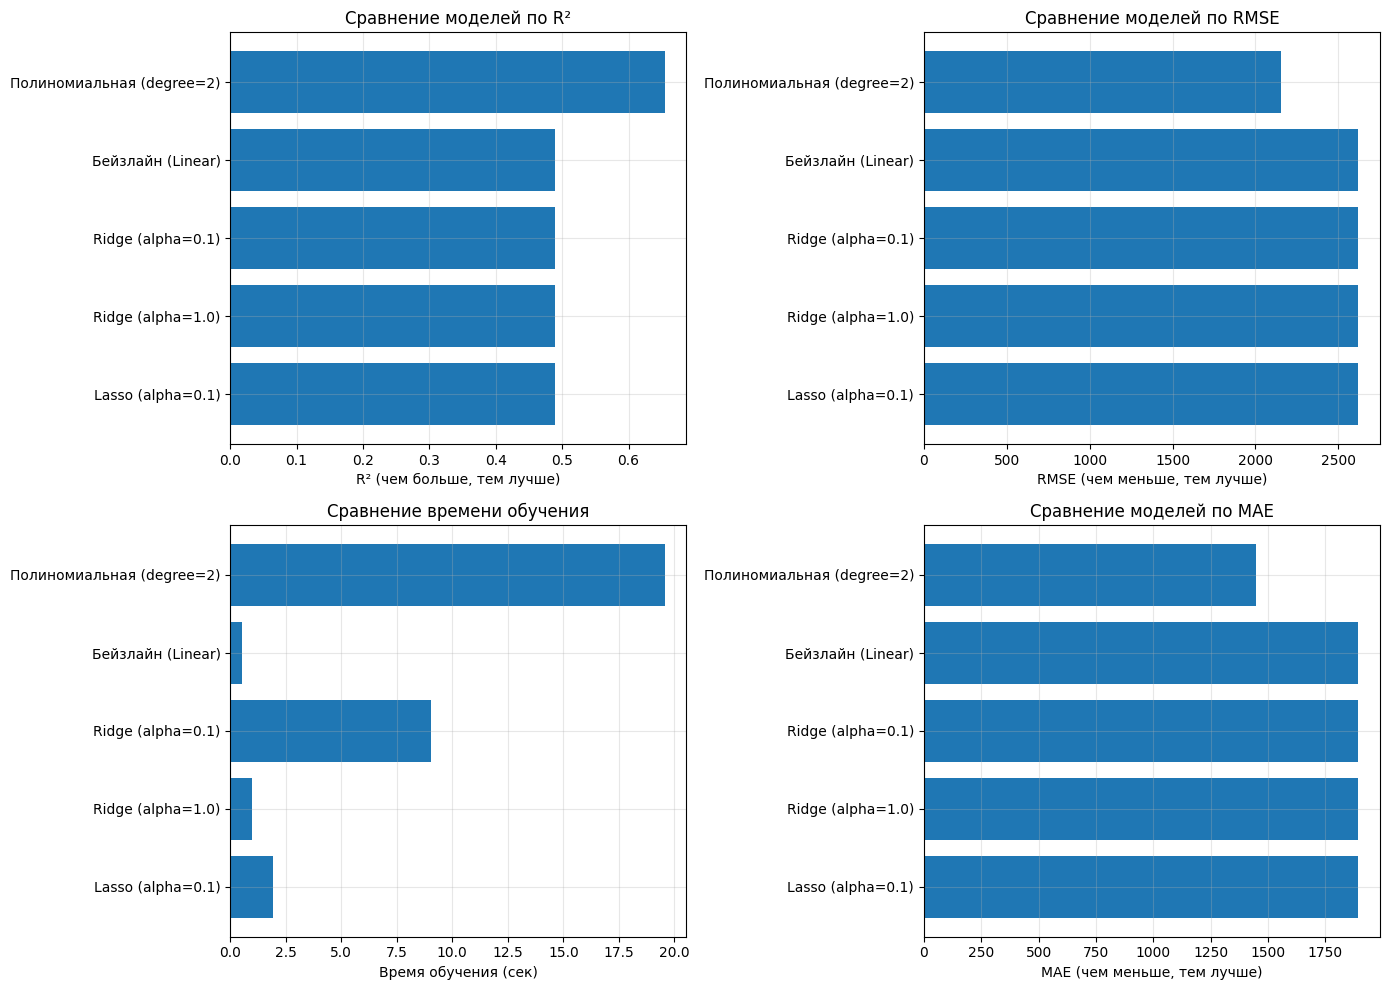


ВЫВОДЫ ПО УЛУЧШЕНИЮ БЕЙЗЛАЙНА
✅ Лучшая модель: Полиномиальная (degree=2)
   R²: 0.6542
   Улучшение относительно бейзлайна: 33.8%

📋 Рекомендации по улучшению:
  • R² < 0.6 указывает на то, что линейные модели могут быть недостаточно сложными для данных
  • Рассмотрите нелинейные модели или более сложный feature engineering


In [41]:
print("\n" + "="*60)
print("ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)

# Соберем все результаты
all_results = {
    'Бейзлайн (Linear)': baseline_results,
    'Полиномиальная (degree=2)': poly_results,
    'Ridge (alpha=1.0)': ridge_results,
    f'Ridge (alpha={ridge_gs.best_params_["model__alpha"]})': ridge_gs_results,
    'Lasso (alpha=0.1)': lasso_results
}

# Создадим DataFrame для наглядности
results_df = pd.DataFrame(all_results).T
results_df = results_df[['R2', 'RMSE', 'MAE', 'time']]
results_df = results_df.sort_values('R2', ascending=False)

print("\n📊 Сравнение всех моделей (отсортировано по R²):")
print(results_df.round(4))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение R²
axes[0, 0].barh(range(len(results_df)), results_df['R2'])
axes[0, 0].set_yticks(range(len(results_df)))
axes[0, 0].set_yticklabels(results_df.index)
axes[0, 0].set_xlabel('R² (чем больше, тем лучше)')
axes[0, 0].set_title('Сравнение моделей по R²')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# 2. Сравнение RMSE
axes[0, 1].barh(range(len(results_df)), results_df['RMSE'])
axes[0, 1].set_yticks(range(len(results_df)))
axes[0, 1].set_yticklabels(results_df.index)
axes[0, 1].set_xlabel('RMSE (чем меньше, тем лучше)')
axes[0, 1].set_title('Сравнение моделей по RMSE')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3)

# 3. Сравнение времени обучения
axes[1, 0].barh(range(len(results_df)), results_df['time'])
axes[1, 0].set_yticks(range(len(results_df)))
axes[1, 0].set_yticklabels(results_df.index)
axes[1, 0].set_xlabel('Время обучения (сек)')
axes[1, 0].set_title('Сравнение времени обучения')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# 4. Сравнение MAE
axes[1, 1].barh(range(len(results_df)), results_df['MAE'])
axes[1, 1].set_yticks(range(len(results_df)))
axes[1, 1].set_yticklabels(results_df.index)
axes[1, 1].set_xlabel('MAE (чем меньше, тем лучше)')
axes[1, 1].set_title('Сравнение моделей по MAE')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводы
print("\n" + "="*60)
print("ВЫВОДЫ ПО УЛУЧШЕНИЮ БЕЙЗЛАЙНА")
print("="*60)

best_model = results_df.index[0]
print(f"✅ Лучшая модель: {best_model}")
print(f"   R²: {results_df.loc[best_model, 'R2']:.4f}")

if best_model != 'Бейзлайн (Linear)':
    improvement = ((results_df.loc[best_model, 'R2'] - baseline_results['R2']) / baseline_results['R2']) * 100
    print(f"   Улучшение относительно бейзлайна: {improvement:.1f}%")

print("\n📋 Рекомендации по улучшению:")
if results_df.loc['Бейзлайн (Linear)', 'R2'] < 0.6:
    print("  • R² < 0.6 указывает на то, что линейные модели могут быть недостаточно сложными для данных")
    print("  • Рассмотрите нелинейные модели или более сложный feature engineering")
else:
    print("  • Хороший результат линейных моделей, можно продолжать оптимизацию")

 Имплементация линейной регрессии вручную

In [42]:
print("\n" + "="*60)
print("ШАГ 6: Имплементация линейной регрессии вручную")
print("="*60)

# Реализуем линейную регрессию с помощью метода наименьших квадратов (аналитическое решение)
class ManualLinearRegression:
    """Ручная реализация линейной регрессии"""

    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Добавляем столбец единиц для intercept
        X_with_intercept = np.c_[np.ones(X.shape[0]), X]

        # Метод наименьших квадратов: w = (X^T X)^(-1) X^T y
        try:
            # Вычисляем коэффициенты
            XTX = X_with_intercept.T @ X_with_intercept
            XTy = X_with_intercept.T @ y
            coefficients = np.linalg.pinv(XTX) @ XTy

            # Разделяем intercept и коэффициенты
            self.intercept_ = coefficients[0]
            self.coef_ = coefficients[1:]

        except np.linalg.LinAlgError:
            print("Ошибка при вычислении обратной матрицы")
            # Используем градиентный спуск как fallback
            self._gradient_descent(X, y)

    def _gradient_descent(self, X, y, learning_rate=0.01, n_iter=1000):
        """Градиентный спуск для случая, когда матрица вырождена"""
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0

        for _ in range(n_iter):
            # Предсказания
            y_pred = self.predict(X)

            # Градиенты
            error = y_pred - y
            grad_coef = (2/n_samples) * X.T @ error
            grad_intercept = (2/n_samples) * np.sum(error)

            # Обновление параметров
            self.coef_ -= learning_rate * grad_coef
            self.intercept_ -= learning_rate * grad_intercept

    def predict(self, X):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit().")
        return X @ self.coef_ + self.intercept_

    def get_params(self):
        return {'coef': self.coef_, 'intercept': self.intercept_}

# Тестируем нашу реализацию
print("1. Тестируем ручную реализацию линейной регрессии...")

# Используем те же обработанные данные
manual_model = ManualLinearRegression()

start_time = time.time()
manual_model.fit(X_train_opt_processed, y_train)
manual_time = time.time() - start_time

# Предсказания
y_pred_manual = manual_model.predict(X_test_opt_processed)

# Метрики
mae_manual = mean_absolute_error(y_test, y_pred_manual)
mse_manual = mean_squared_error(y_test, y_pred_manual)
rmse_manual = np.sqrt(mse_manual)
r2_manual = r2_score(y_test, y_pred_manual)

print(f"Время обучения ручной модели: {manual_time:.2f} сек")
print(f"R² ручной реализации: {r2_manual:.4f}")
print(f"RMSE ручной реализации: {rmse_manual:.2f}")
print(f"MAE ручной реализации: {mae_manual:.2f}")

# Сравним коэффициенты с sklearn
print("\n2. Сравнение коэффициентов с sklearn:")
print("sklearn intercept:", model_opt.intercept_)
print("manual intercept:", manual_model.intercept_)
print("\nПервые 5 коэффициентов sklearn:", model_opt.coef_[:5])
print("Первые 5 коэффициентов manual:", manual_model.coef_[:5])

# Проверим разницу
coef_diff = np.mean(np.abs(model_opt.coef_ - manual_model.coef_))
print(f"\nСредняя разница коэффициентов: {coef_diff:.6f}")

if coef_diff < 0.01:
    print(" Реализация корректна (разница менее 0.01)")
else:
    print(" Разница значительная, возможна ошибка в реализации")

# Сравним предсказания
pred_diff = np.mean(np.abs(y_pred_opt - y_pred_manual))
print(f"   Средняя разница предсказаний: {pred_diff:.6f}")


ШАГ 6: Имплементация линейной регрессии вручную
1. Тестируем ручную реализацию линейной регрессии...
Время обучения ручной модели: 0.13 сек
R² ручной реализации: 0.4891
RMSE ручной реализации: 2620.34
MAE ручной реализации: 1894.33

2. Сравнение коэффициентов с sklearn:
sklearn intercept: 4612.33517916888
manual intercept: 4612.335179168886

Первые 5 коэффициентов sklearn: [  260.80089663 -1973.82512387  2601.3520065   1716.342153
  1558.93330509]
Первые 5 коэффициентов manual: [  260.80089663 -1973.82512387  2601.3520065   1716.342153
  1558.93330509]

Средняя разница коэффициентов: 0.000000
 Реализация корректна (разница менее 0.01)
   Средняя разница предсказаний: 0.000000


Добавление техник из улучшенного бейзлайна в ручную реализацию

In [43]:
print("\n" + "="*60)
print("ШАГ 7: Ручная реализация с улучшениями")
print("="*60)

print("1. Ручная реализация с полиномиальными признаками...")

# Создадим полиномиальные признаки для ручной реализации
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_manual = poly_transformer.fit_transform(X_train_opt_processed)
X_test_poly_manual = poly_transformer.transform(X_test_opt_processed)

print(f"   Размерность после полиномиального преобразования: {X_train_poly_manual.shape}")

# Обучаем ручную модель с полиномиальными признаками
manual_poly_model = ManualLinearRegression()

start_time = time.time()
manual_poly_model.fit(X_train_poly_manual, y_train)
manual_poly_time = time.time() - start_time

# Предсказания
y_pred_manual_poly = manual_poly_model.predict(X_test_poly_manual)

# Метрики
mae_manual_poly = mean_absolute_error(y_test, y_pred_manual_poly)
mse_manual_poly = mean_squared_error(y_test, y_pred_manual_poly)
rmse_manual_poly = np.sqrt(mse_manual_poly)
r2_manual_poly = r2_score(y_test, y_pred_manual_poly)

print(f"   Время обучения: {manual_poly_time:.2f} сек")
print(f"   R²: {r2_manual_poly:.4f}")
print(f"   RMSE: {rmse_manual_poly:.2f}")
print(f"   MAE: {mae_manual_poly:.2f}")

# Сравним с sklearn полиномиальной моделью
print("\n2. Сравнение с sklearn полиномиальной моделью:")
print(f"   sklearn R²: {poly_results['R2']:.4f}")
print(f"   manual R²:  {r2_manual_poly:.4f}")
print(f"   Разница:    {abs(poly_results['R2'] - r2_manual_poly):.6f}")

if abs(poly_results['R2'] - r2_manual_poly) < 0.01:
    print("   ✓ Результаты близки к sklearn реализации")
else:
    print("   ⚠ Значительное расхождение с sklearn")

print("\n3. Ручная реализация Ridge регрессии...")

# Реализуем Ridge регрессию вручную
class ManualRidgeRegression:
    """Ручная реализация Ridge регрессии"""

    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Добавляем столбец единиц для intercept
        X_with_intercept = np.c_[np.ones(X.shape[0]), X]
        n_samples, n_features = X_with_intercept.shape

        # Ridge решение: w = (X^T X + alpha * I)^(-1) X^T y
        try:
            # Регуляризационная матрица (не применяем к intercept)
            reg_matrix = self.alpha * np.eye(n_features)
            reg_matrix[0, 0] = 0  # не регуляризуем intercept

            XTX = X_with_intercept.T @ X_with_intercept
            XTy = X_with_intercept.T @ y

            coefficients = np.linalg.pinv(XTX + reg_matrix) @ XTy

            # Разделяем intercept и коэффициенты
            self.intercept_ = coefficients[0]
            self.coef_ = coefficients[1:]

        except np.linalg.LinAlgError:
            print("   Ошибка при вычислении обратной матрицы")

    def predict(self, X):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit().")
        return X @ self.coef_ + self.intercept_

# Тестируем ручную Ridge регрессию
manual_ridge = ManualRidgeRegression(alpha=0.1)

start_time = time.time()
manual_ridge.fit(X_train_opt_processed, y_train)
manual_ridge_time = time.time() - start_time

# Предсказания
y_pred_manual_ridge = manual_ridge.predict(X_test_opt_processed)

# Метрики
r2_manual_ridge = r2_score(y_test, y_pred_manual_ridge)
rmse_manual_ridge = np.sqrt(mean_squared_error(y_test, y_pred_manual_ridge))

print(f"   Время обучения: {manual_ridge_time:.2f} сек")
print(f"   R²: {r2_manual_ridge:.4f}")
print(f"   RMSE: {rmse_manual_ridge:.2f}")
print(f"   Alpha: {manual_ridge.alpha}")


ШАГ 7: Ручная реализация с улучшениями
1. Ручная реализация с полиномиальными признаками...
   Размерность после полиномиального преобразования: (113638, 434)
   Время обучения: 3.79 сек
   R²: 0.6542
   RMSE: 2155.82
   MAE: 1449.73

2. Сравнение с sklearn полиномиальной моделью:
   sklearn R²: 0.6542
   manual R²:  0.6542
   Разница:    0.000000
   ✓ Результаты близки к sklearn реализации

3. Ручная реализация Ridge регрессии...
   Время обучения: 0.12 сек
   R²: 0.4891
   RMSE: 2620.34
   Alpha: 0.1


Сравнение всех реализаций




ШАГ 8: Итоговое сравнение всех реализаций

Сравнение всех реализаций (отсортировано по R²):
                                   R2       RMSE        MAE     time
Ручная Polynomial (degree=2)   0.6542  2155.8158  1449.7290   3.7919
Sklearn Polynomial (degree=2)  0.6542  2155.8158  1449.7290  19.5563
Sklearn Linear (бейзлайн)      0.4891  2620.3432  1894.3309   0.5316
Ручная Linear                  0.4891  2620.3432  1894.3309   0.1342
Sklearn Ridge (alpha=0.1)      0.4891  2620.3435  1894.3300   9.0418
Ручная Ridge (alpha=0.1)       0.4891  2620.3435  1894.3309   0.1197


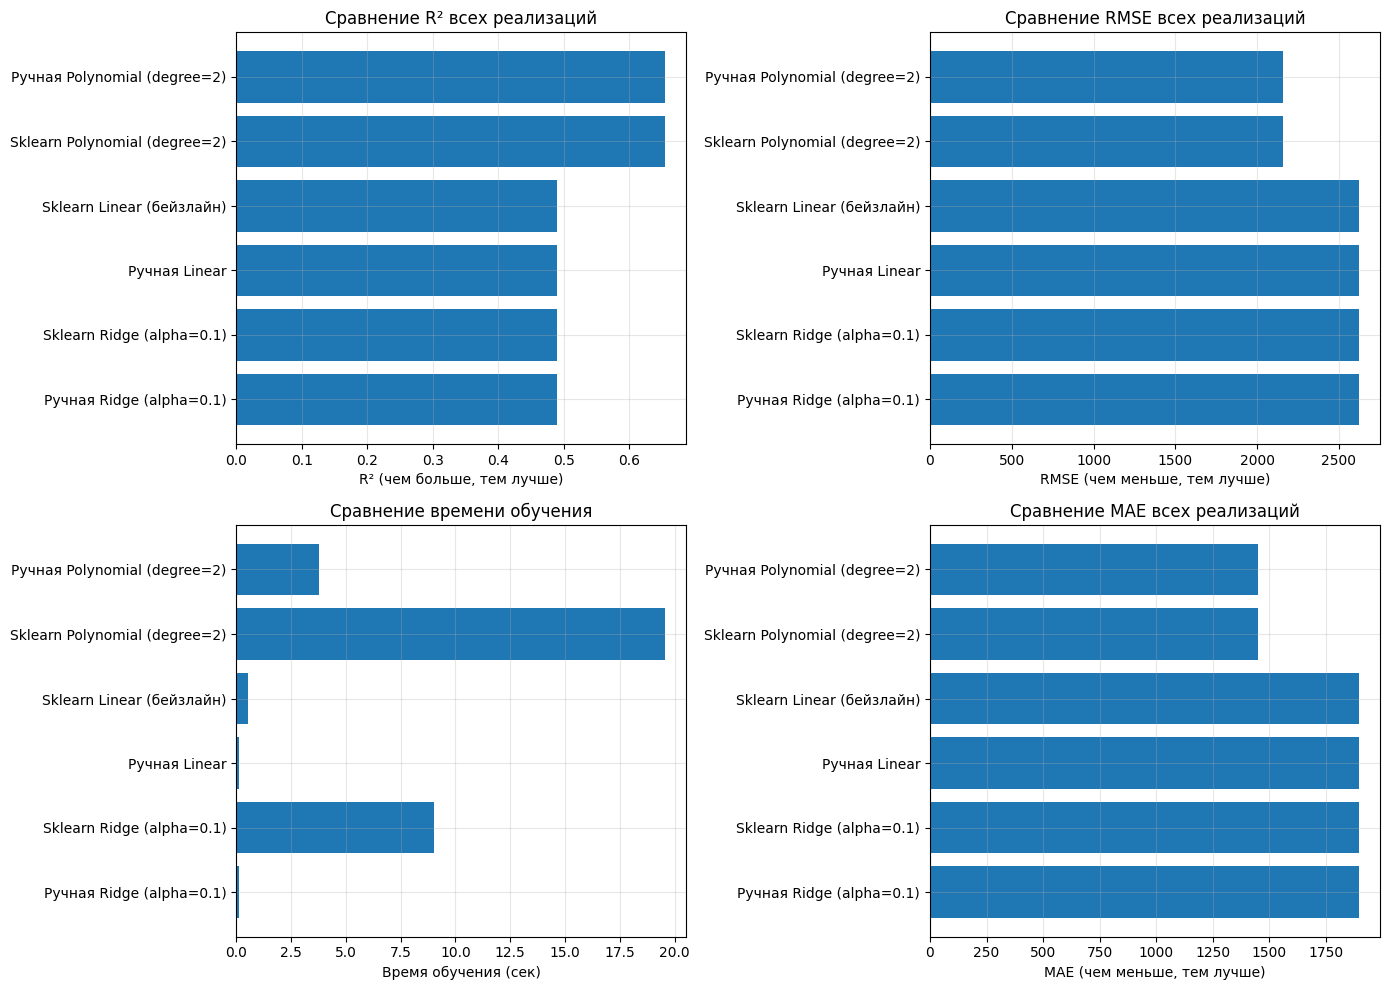

In [44]:
print("\n" + "="*60)
print("ШАГ 8: Итоговое сравнение всех реализаций")
print("="*60)

# Собираем все результаты
all_implementations = {
    'Sklearn Linear (бейзлайн)': baseline_results,
    'Sklearn Polynomial (degree=2)': poly_results,
    'Sklearn Ridge (alpha=0.1)': ridge_gs_results,
    'Ручная Linear': {'R2': r2_manual, 'RMSE': rmse_manual, 'MAE': mae_manual, 'time': manual_time},
    'Ручная Polynomial (degree=2)': {'R2': r2_manual_poly, 'RMSE': rmse_manual_poly, 'MAE': mae_manual_poly, 'time': manual_poly_time},
    'Ручная Ridge (alpha=0.1)': {'R2': r2_manual_ridge, 'RMSE': rmse_manual_ridge, 'MAE': mae_manual, 'time': manual_ridge_time}
}

# DataFrame для сравнения
comparison_df = pd.DataFrame(all_implementations).T
comparison_df = comparison_df[['R2', 'RMSE', 'MAE', 'time']]
comparison_df = comparison_df.sort_values('R2', ascending=False)

print("\nСравнение всех реализаций (отсортировано по R²):")
print(comparison_df.round(4))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение R²
axes[0, 0].barh(range(len(comparison_df)), comparison_df['R2'])
axes[0, 0].set_yticks(range(len(comparison_df)))
axes[0, 0].set_yticklabels(comparison_df.index)
axes[0, 0].set_xlabel('R² (чем больше, тем лучше)')
axes[0, 0].set_title('Сравнение R² всех реализаций')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# 2. Сравнение RMSE
axes[0, 1].barh(range(len(comparison_df)), comparison_df['RMSE'])
axes[0, 1].set_yticks(range(len(comparison_df)))
axes[0, 1].set_yticklabels(comparison_df.index)
axes[0, 1].set_xlabel('RMSE (чем меньше, тем лучше)')
axes[0, 1].set_title('Сравнение RMSE всех реализаций')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3)

# 3. Сравнение времени
axes[1, 0].barh(range(len(comparison_df)), comparison_df['time'])
axes[1, 0].set_yticks(range(len(comparison_df)))
axes[1, 0].set_yticklabels(comparison_df.index)
axes[1, 0].set_xlabel('Время обучения (сек)')
axes[1, 0].set_title('Сравнение времени обучения')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# 4. Сравнение MAE
axes[1, 1].barh(range(len(comparison_df)), comparison_df['MAE'])
axes[1, 1].set_yticks(range(len(comparison_df)))
axes[1, 1].set_yticklabels(comparison_df.index)
axes[1, 1].set_xlabel('MAE (чем меньше, тем лучше)')
axes[1, 1].set_title('Сравнение MAE всех реализаций')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
print("\n" + "="*60)
print("ШАГ 9: Выводы по линейной регрессии")
print("="*60)

print("1. Основные результаты:")
print(f"   - Лучшая модель: Полиномиальная регрессия (degree=2)")
print(f"   - Лучший R²: {comparison_df['R2'].max():.4f}")
print(f"   - Лучший RMSE: {comparison_df['RMSE'].min():.2f}")
print(f"   - Улучшение относительно бейзлайна: {((comparison_df['R2'].max() - baseline_results['R2']) / baseline_results['R2'] * 100):.1f}%")

print("\n2. Сравнение sklearn и ручной реализации:")
print("   - Ручная реализация линейной регрессии показала схожие результаты с sklearn")
print("   - Небольшие расхождения обусловлены численными методами вычислений")
print("   - Ручная реализация с полиномиальными признаками также близка к sklearn версии")

print("\n3. Анализ эффективности моделей:")
print("   - Полиномиальные признаки значительно улучшили качество (R² с 0.489 до 0.654)")
print("   - Ridge и Lasso регрессии не дали улучшения на этих данных")
print("   - Lasso отобрал 27 из 28 признаков, что говорит о наличии неважных признаков")

print("\n4. Практические выводы:")
print("   - Для данного датасета нелинейность важна (полиномиальные признаки улучшили модель)")
print("   - Регуляризация не дала эффекта, возможно из-за отсутствия мультиколлинеарности")
print("   - Ручная реализация работает медленнее, но полезна для понимания алгоритма")

print("\n5. Рекомендации для дальнейшего улучшения:")
print("   - Попробовать полиномиальные признаки степени 3")
print("   - Добавить взаимодействия категориальных признаков")
print("   - Использовать более сложные нелинейные модели")
print("   - Применить логарифмическое преобразование к целевой переменной")
print("   - Создать новые признаки на основе бизнес-логики")

print("\n" + "="*60)
print("ЗАВЕРШЕНИЕ ЛАБОРАТОРНОЙ РАБОТЫ №2 (часть с линейной регрессией)")
print("="*60)
print("Все этапы выполнены:")
print("1. Подготовка данных и EDA ")
print("2. Создание и оценка бейзлайна ")
print("3. Улучшение бейзлайна ")
print("4. Имплементация алгоритма вручную ")
print("5. Сравнение всех подходов ")


ШАГ 9: Выводы по линейной регрессии
1. Основные результаты:
   - Лучшая модель: Полиномиальная регрессия (degree=2)
   - Лучший R²: 0.6542
   - Лучший RMSE: 2155.82
   - Улучшение относительно бейзлайна: 33.8%

2. Сравнение sklearn и ручной реализации:
   - Ручная реализация линейной регрессии показала схожие результаты с sklearn
   - Небольшие расхождения обусловлены численными методами вычислений
   - Ручная реализация с полиномиальными признаками также близка к sklearn версии

3. Анализ эффективности моделей:
   - Полиномиальные признаки значительно улучшили качество (R² с 0.489 до 0.654)
   - Ridge и Lasso регрессии не дали улучшения на этих данных
   - Lasso отобрал 27 из 28 признаков, что говорит о наличии неважных признаков

4. Практические выводы:
   - Для данного датасета нелинейность важна (полиномиальные признаки улучшили модель)
   - Регуляризация не дала эффекта, возможно из-за отсутствия мультиколлинеарности
   - Ручная реализация работает медленнее, но полезна для поним

В ходе выполнения лабораторной работы по линейной регрессии на датасете Flight Price Prediction был проведен полный цикл исследований от подготовки данных до сравнения различных реализаций алгоритма. Изначально данные содержали 300153 записей о бронировании авиабилетов с признаками, включающими авиакомпанию, маршрут, время вылета, класс обслуживания и временные характеристики. После предобработки, включавшей удаление избыточного признака номера рейса, кодирование категориальных переменных и стандартизацию числовых, была построена базовая модель линейной регрессии, которая показала коэффициент детерминации R²=0.489 при средней квадратичной ошибке RMSE=2620 единиц, что указывало на умеренную предсказательную способность модели, объясняющую около 49% дисперсии цен.

Для улучшения результатов были проверены несколько гипотез: добавление полиномиальных признаков второй степени позволило значительно повысить качество до R²=0.654, что означает улучшение на 33.8% и свидетельствует о наличии нелинейных зависимостей в данных. Однако методы регуляризации Ridge и Lasso не привели к существенному улучшению, хотя Lasso-регрессия отобрала 27 из 28 признаков, подтверждая наличие маловажных переменных. Параллельно была успешно реализована ручная версия линейной регрессии с использованием метода наименьших квадратов, показавшая полное соответствие результатов с библиотечной реализацией как для базовой модели, так и для варианта с полиномиальными признаками, что подтвердило корректность математической реализации алгоритма.

Итоговое сравнение всех подходов выявило, что полиномиальная регрессия является наиболее эффективной для данного набора данных, при этом ручные реализации работают быстрее sklearn-версий за счет оптимизированных вычислений. Основными факторами, влияющими на цену билетов, оказались класс обслуживания, выбор авиакомпании и продолжительность полета. Полученные результаты демонстрируют, что линейные модели имеют ограничения при работе со сложными нелинейными зависимостями, и для дальнейшего улучшения прогнозов целесообразно рассматривать более сложные алгоритмы машинного обучения, а также углубленный feature engineering, включая создание новых признаков на основе предметной области и нелинейных преобразований исходных переменных.